# Stock Prediction using LSTM

Objective: use LSTM (Long Short-Term Memory) Neural Network to predict stock prices.   This type of neural network can be applied to time-series prediction problem.  This is the first attempt using LSTM and will be followed with others (Univariant, Multi-variant, Multi-step).

Based on: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [16]:
from __future__ import print_function
import numpy as np 
import pandas as pd

import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime as dt, timedelta
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

# to not display the warnings of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# set random seed for reproducibility
np.random.seed(123)

Download Stock data for Apple (AAPL)

In [2]:
ticker = "AAPL"
start = dt.today() - timedelta(days=5*365)
end = dt.now()

df = web.DataReader(ticker, 'iex', start, end)

# convert index to datetime
df.index = pd.to_datetime(df.index)

5y


Convert close price to float and reshape to column vector

In [3]:
# save stock close as float
stock_prices = df.close.values.astype('float32')

# reshape to column vector
stock_prices = stock_prices.reshape(len(stock_prices), 1)

Calculate train / test size (70/30 split)

In [4]:
train_size = int(len(stock_prices) * 0.7)
test_size = len(stock_prices) - train_size

Normalize the data using sklearn scaler

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

# save scaled close price for review/visualization
df['scaled_close'] = stock_prices

Train/test split on scaled data

In [6]:
train, test = stock_prices[0:train_size,:], stock_prices[train_size:len(stock_prices),:]

print('Number of training samples/ test samples:', len(train), len(test))

Number of training samples/ test samples: 880 378


Function to convert an array of values into a time series dataset

Result after function call

** Insert "LSTM Figure 1.png"**

In [7]:
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert Apple's stock price data into time series dataset
X_train, y_train = create_dataset(train, 7)
X_test, y_test = create_dataset(test, 7)

Reshape input of the LSTM to be format [samples, time steps, features]

**Insert "LSTM Figure 2.png"**

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Create and fit the LSTM network

TODO: add more hidden layers

In [9]:
model = Sequential()
model.add(LSTM(4, input_shape=(7, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=3)

Epoch 1/100
872/872 [==============================] - 3s 3ms/step - loss: 0.0566
Epoch 2/100
872/872 [==============================] - 2s 2ms/step - loss: 0.0111
Epoch 3/100
872/872 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 4/100
872/872 [==============================] - 2s 2ms/step - loss: 7.1254e-04
Epoch 5/100
872/872 [==============================] - 2s 2ms/step - loss: 3.8680e-04
Epoch 6/100
872/872 [==============================] - 2s 2ms/step - loss: 3.7057e-04
Epoch 7/100
872/872 [==============================] - 2s 2ms/step - loss: 3.6130e-04
Epoch 8/100
872/872 [==============================] - 2s 2ms/step - loss: 3.5449e-04
Epoch 9/100
872/872 [==============================] - 2s 3ms/step - loss: 3.3468e-04
Epoch 10/100
872/872 [==============================] - 2s 2ms/step - loss: 3.1668e-04
Epoch 11/100
872/872 [==============================] - 2s 2ms/step - loss: 3.2375e-04
Epoch 12/100
872/872 [==============================] - 2s 2ms/s

872/872 [==============================] - 2s 2ms/step - loss: 1.1772e-04
Epoch 96/100
872/872 [==============================] - 2s 2ms/step - loss: 1.2107e-04
Epoch 97/100
872/872 [==============================] - 2s 2ms/step - loss: 1.1544e-04
Epoch 98/100
872/872 [==============================] - 2s 2ms/step - loss: 1.1428e-04
Epoch 99/100
872/872 [==============================] - 2s 2ms/step - loss: 1.2554e-04
Epoch 100/100
872/872 [==============================] - 2s 2ms/step - loss: 1.1456e-04


### Make predictions

In [10]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Unscale predictions and targets

In [11]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

Calculate root mean squared error

In [12]:
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.59 RMSE
Test Score: 8.18 RMSE


### Create a DataFrame for visualization

In [13]:
# get the test data from web dataset
df_plot = df.iloc[len(df) - len(testPredict):len(df),:]

In [14]:
# setup date column
df_plot['date'] = df_plot.index
df_plot.reset_index(drop=True, inplace=True)

# add the predictions in
df_plot['prediction'] = pd.DataFrame(testPredict)
df_plot['date'] = pd.to_datetime(df_plot['date'])

# reset index
df_plot.set_index('date', inplace=True)

### Plot Stock Price with Prediction

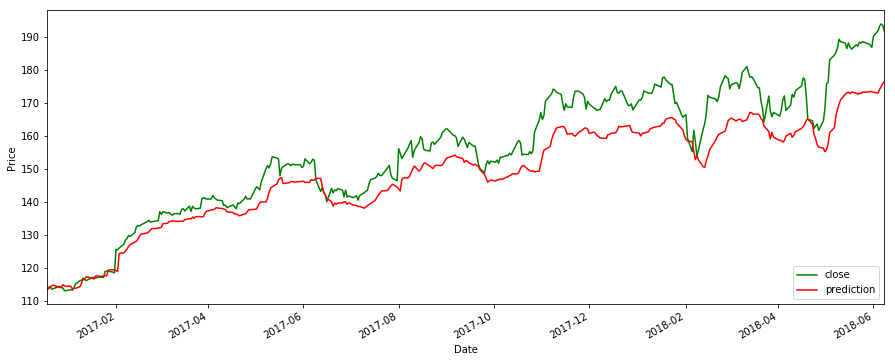

In [17]:
df_plot['close'].plot(figsize=(15,6), color="green")
df_plot['prediction'].plot(figsize=(15,6), color="red")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Conclusion 

There you have it.  Although not perfect, LSTM does a fairly good job in its prediction.  Later I will add more hidden layers to see if the model improves.

It would be interesting to see how well it predicts stock price movement.  When time permits I'll give that a go!